# __Name__

За даними акселерометра з мобільного телефону потрібно __класифікувати, якою діяльністю займається людина__: йде, стоїть, біжить чи йде по сходах.
<br>
Алгоритми `SVM` та `випадковий ліс` з бібліотеки `scikit-learn`. Як характеристики, проте покращити результати роботи алгоритмів, спочатку підготувати датасет і розрахувати часові ознаки (`time domain features`).

In [29]:
from itertools import combinations
import math as m
import os
from pathlib import Path
import pickle
import random
from typing import Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
import tsfresh  # poetry add tsfresh
%matplotlib inline


In [30]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    # tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'


set_seed(1)

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

- https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
- https://pandas.pydata.org/docs/reference/api/pandas.concat.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurt.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.var.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
- https://stackoverflow.com/questions/53177327/how-to-compute-shannon-entropy-of-information-from-a-pandas-dataframe
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [31]:
def read_from_csvfile(file: Path) -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file)
    
    return df

In [32]:
df = pd.DataFrame()
classification_human_activity = {}

In [33]:
def get_statistical_features(y: str, df: pd.DataFrame) -> pd.DataFrame:
    # y - type real data; df - sample data. 
    if y not in classification_human_activity:
        classification_human_activity[y] = len(classification_human_activity)

    data = {'activity': [classification_human_activity[y]]}

    [data.update({
                  f'max_{col[-1]}':[max(df[col])],
                  f'min_{col[-1]}':[min(df[col])],
                  f'mean_{col[-1]}':[df[col].mean(axis=0)],
                  f'med_{col[-1]}':[df[col].median(axis=0)],  # median
                  f'std_{col[-1]}':[df[col].std(axis=0)],  # Standard deviation
                  f'skew_{col[-1]}':[df[col].skew(axis=0)],  # skewness
                  f'kurt_{col[-1]}':[df[col].kurt(axis=0)],  # kurtosis
                  f'var_{col[-1]}':[df[col].var(axis=0)],  # variance
                  f'idxmax_{col[-1]}':[df[col].idxmax(axis=0)],  # index of first occurrence of maximum over requested axis
                  f'idxmin_{col[-1]}':[df[col].idxmin(axis=0)],  # index of first occurrence of minimum over requested axis
                  }) 
        for col in df.columns]

    [data.update({
                  f'rmse_{col[-1]}':[mean_squared_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])], squared=False)],  # variance# Root Mean Square Error
                  f'mae_{col[-1]}':[mean_absolute_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])])],  # mean absolute error
                  }) 
        for col in df.columns]
    
    df_f = pd.DataFrame(data)
    
    return df_f

In [34]:
def get_data_to_dafaframe(path: Union[str, Path], df: pd.DataFrame, get_features: callable) -> pd.DataFrame:
    path = Path(path)
    if not path.is_dir() or not path.exists():
        return None
    
    for file_system_object in path.iterdir():
        if file_system_object.is_dir():
            df = get_data_to_dafaframe(file_system_object, df, get_features)
            
        elif file_system_object.suffix.lower() in ('.csv',):
            df_add = read_from_csvfile(file_system_object)
            df = pd.concat([df, get_features(file_system_object.stem.split('-')[0], df_add)], ignore_index=True)

    return df

In [35]:
def save_prepared_data(df: pd.DataFrame, file_name: str='data_0.bin') -> None:
    with open(file_name, 'wb') as fh:
        pickle.dump(df, fh)

In [36]:
def load_prepared_data(file_name: str='data_0.bin') -> pd.DataFrame:
    with open(file_name, 'rb') as fh:
        df = pickle.load(fh)

    return df

Якщо немає підготовлених даних (`data0.bin` & `data1.bin`) - обробляємо знову з сирих

In [37]:
if Path('data0.bin').is_file() and Path('data1.bin').is_file():
    df = load_prepared_data('data1.bin')
    classification_human_activity = load_prepared_data('data0.bin')

else:
    df = get_data_to_dafaframe('adata', df, get_statistical_features)
    save_prepared_data(df, 'data1.bin')
    save_prepared_data(classification_human_activity, 'data0.bin')

In [38]:
df.tail(3)

,activity,max_X,min_X,mean_X,med_X,std_X,skew_X,kurt_X,var_X,idxmax_X,...,kurt_Z,var_Z,idxmax_Z,idxmin_Z,rmse_X,mae_X,rmse_Y,mae_Y,rmse_Z,mae_Z
6459,3,8.073248,-4.582502,2.830745,3.447650,3.302172,-0.492919,-0.453013,10.904337,11,...,3.758635,20.366468,27,29,3.246669,2.650009,4.630977,3.314692,4.437069,2.83880
6460,3,9.035717,-6.904877,-0.025219,-0.399831,3.414785,0.284005,0.775833,11.660759,1,...,2.128289,19.916885,1,29,3.357390,2.592356,5.177956,3.986420,4.387823,2.95603
6461,3,8.398860,-6.224924,0.964544,1.376666,2.958615,-0.059084,0.721621,8.753403,20,...,4.863290,39.297190,19,23,2.908887,2.250614,4.252132,3.073357,6.163382,4.05880


Розшифровка позначень типів діяльності

In [39]:
classification_human_activity

{'walking': 0, 'running': 1, 'idle': 2, 'stairs': 3}

In [40]:
if not classification_human_activity.get(0):
    classification_human_activity = {val:key for key, val in classification_human_activity.items()}

classification_human_activity

{0: 'walking', 1: 'running', 2: 'idle', 3: 'stairs'}

In [41]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [42]:
X.shape

(6462, 36)

In [43]:
y.shape

(6462,)

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

(рандомне перемішування даних shuffle=True може помітно впливати на результати співставлення різних алгоритмів, усереднено - орієнтовно достатня точність)

In [44]:
y = y.values

In [45]:
# Робимо вибірки - розділяємо всі дані на групи для тренування, валідаційну та тестову (stratify для рівномірного розподілу за значенням y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 36), (1066, 36), (1067, 36), (4329,), (1066,), (1067,))

### __`MODEL`__ & __`Training`__

- https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [46]:
C = [10**q for q in range(-3, 4)]  # 7
gamma = [10**g for g in range(-2, 1)]  # 3+
gamma.append('auto')
degree = [d for d in range(2,7)]  # 6

models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}

In [47]:
number_of_trees = [2**(trees+1) for trees in range(1, 7)]  # 6
models_RF = {f'RF_n_est={items}':RandomForestClassifier(n_estimators=items).fit(X_train, y_train) for items in number_of_trees}

### __`INTERPRET`__ / __`Error Analysis`__

In [48]:
# для отримання значення моделей за валідаційними/тестовими вибірками і перевіримо узагальнену точність [accuracy_score, f1_score, ]
def run_model(model: Union[SVC, RandomForestClassifier], new_data: pd.DataFrame, real_result: pd.Series) -> list:
    y_valid_pred = model.predict_proba(new_data)  # [:, 2]  # probability for classification_human_activity[2] - для 'idle'
    # визначаємо клас(и) з результатів за максимальною ймовірністю зі значень для всіх класів:
    from_model_by_max = pd.DataFrame(y_valid_pred).idxmax(1).values  
    m1 = accuracy_score(real_result, from_model_by_max)
    m2 = f1_score(real_result, from_model_by_max, average='weighted')  # average=None - for each class
    
    return [m1, m2]  # metric results

In [49]:
# для прорахунку результатів перевірки за моделями (валідації/тесту...)
def get_model_results(
                      X_valid: pd.DataFrame, 
                      y_valid: pd.Series, 
                      sets_of_models: list,
                      ) -> pd.DataFrame:
    valid_results = {}
    for model_set in sets_of_models:
        models = {mark:run_model(model, X_valid, y_valid) for mark, model in model_set.items()} if model_set else {}
        valid_results.update(models)

    valid_results = pd.DataFrame(valid_results).T

    valid_results.columns = ['accuracy_score', 'f1_score', ]

    return valid_results

In [50]:
# Порахуємо результати узагальнених точностей за різними моделями для різних вибірок
train_results = get_model_results(X_train, y_train, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])
valid_results = get_model_results(X_valid, y_valid, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])
test_results = get_model_results(X_test, y_test, [models_svc_linear, models_svc_rbf, models_svc_poly, models_RF])

###### Comparison of results

In [51]:
# для порівняння результатів візуально
def show_compare_accuracy_scatter(x: pd.Series, data: pd.DataFrame) -> None:
    plt.figure(figsize=(int(x.shape[0]/4), 6))
    [ax := sns.scatterplot(x=x, y=ac, data=data, label=ac) for ac in valid_results.columns]

    plt.xticks(rotation=85)
    plt.ylabel('accuracy value', fontsize='small', color='midnightblue')
    plt.grid()
    ax.legend()
    plt.show()

- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
- https://www.geeksforgeeks.org/how-to-sort-pandas-dataframe/

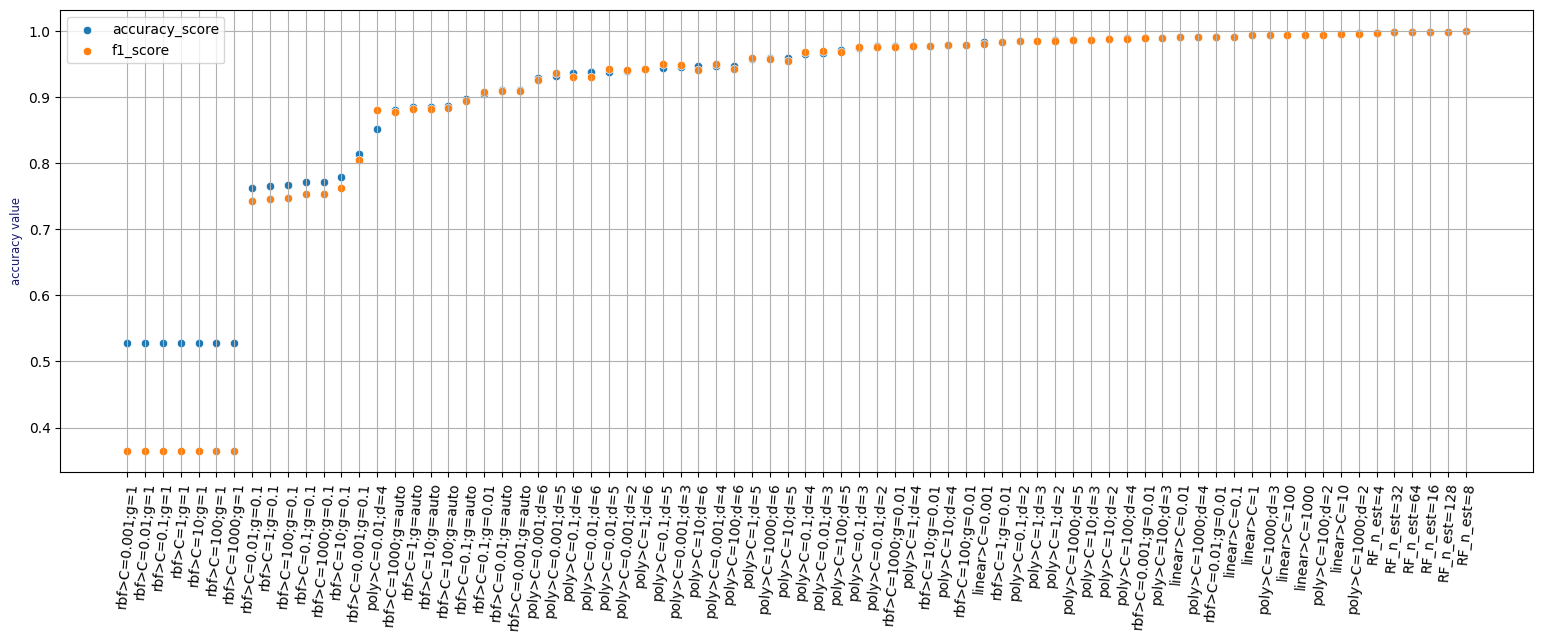

In [52]:
# Порівняння точності за тестовими вибірками для різних моделей
test_results = test_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=test_results.index, data=test_results)

In [53]:
test_results[test_results['accuracy_score'] >= 0.995]

,accuracy_score,f1_score
linear>C=10,0.995314,0.995274
poly>C=1000;d=2,0.996251,0.996185
RF_n_est=4,0.997188,0.997164
RF_n_est=32,0.998126,0.998126
RF_n_est=64,0.998126,0.998126
RF_n_est=16,0.999063,0.999071
RF_n_est=128,0.999063,0.999071
RF_n_est=8,1.000000,1.000000


In [54]:
best_model = models_svc_linear.get('RF_n_est=8')

In [55]:
data = pd.DataFrame(best_model.coef_)
data.columns = X.columns
data = data.abs()
data = data.iloc[-1].sort_values()
biggest = data[data.values >= 0.5*data.max()].index
biggest  # 'найважливіші' фічі серед усіх:

Index(['max_Y', 'med_Y', 'mean_Z', 'mean_Y', 'med_Z', 'min_Z', 'min_Y'], dtype='object')

### __`RESULTS`__ (implement)

In [73]:
df.tail(1).iloc[:, 1:]  # activity = 3

,max_X,min_X,mean_X,med_X,std_X,skew_X,kurt_X,var_X,idxmax_X,idxmin_X,...,kurt_Z,var_Z,idxmax_Z,idxmin_Z,rmse_X,mae_X,rmse_Y,mae_Y,rmse_Z,mae_Z
6461,8.39886,-6.224924,0.964544,1.376666,2.958615,-0.059084,0.721621,8.753403,20,23,...,4.86329,39.29719,19,23,2.908887,2.250614,4.252132,3.073357,6.163382,4.0588


In [76]:
predict = np.argmax(best_model.predict_proba(df.tail(1).iloc[:, 1:]), axis=1)[0]
predict

3

In [77]:
classification_human_activity.get(predict)

'stairs'